## Retrieve data

In [1]:
import os
from collections import Counter
from tqdm import tqdm


data_dir = "/media/aziz/Data/Aziz/data/gans_for_apr/"

print("Collecting file paths...")
file_paths = [root+'/'+name for root, dirs, files in tqdm(os.walk(data_dir)) for name in files]
buggy_paths, fixed_paths = [], []
buggy_paths = [f_path for f_path in tqdm(file_paths) if 'buggy' in f_path]
fixed_paths = [f_path for f_path in tqdm(file_paths) if 'fixed' in f_path]

print("Collecting file contents...")
buggy_data = []
for path in tqdm(buggy_paths):
    with open(path, 'r', encoding='utf-8') as f:
        buggy_data.append(f.read())
fixed_data = []
for path in tqdm(fixed_paths):
    with open(path, 'r', encoding='utf-8') as f:
        fixed_data.append(f.read())

print('Number of processed files:-')
print(len(buggy_data), 'buggy files +', len(fixed_data), 'fixed files = ', len(buggy_data)+len(fixed_data), 'files')

5316it [00:00, 53156.50it/s]

20828it [00:00, 63256.34it/s]
 56%|█████▌    | 11669/20826 [00:00<00:00, 58272.66it/s]

100%|██████████| 20826/20826 [00:00<00:00, 58634.66it/s]

Number of processed files:-
20826 buggy files + 20826 fixed files =  41652 files


## Clean data - Reduce noise

### Remove comments

In [2]:
import re


def remove_comments(code):
    code = re.sub('(?s)/\*.*?\*/', '', code)
    return re.sub('(//[^\n]*)', '', code)


buggy_no_comments = [remove_comments(x) for x in tqdm(buggy_data)]
fixed_no_comments = [remove_comments(x) for x in tqdm(fixed_data)]
print('Comments have been removed')

100%|██████████| 20826/20826 [00:00<00:00, 114849.89it/s]

Comments have been removed


### Remove unnecessary white spaces

In [3]:
def remove_spaces(code):
    '''This function removes excessive spaces and keeps necessary ones'''
    code = code.splitlines()
    result = []
    for line in code:
        line = line.split()
        line = ' '.join(line)
        if len(line) > 0:  # Remove empty lines
            result.append(line)
    
    return '\n'.join(result)


buggy_no_spaces = [remove_spaces(x) for x in tqdm(buggy_no_comments)]
fixed_no_spaces = [remove_spaces(x) for x in tqdm(fixed_no_comments)]
print('White spaces have been removed')

100%|██████████| 20826/20826 [00:00<00:00, 30570.23it/s]

White spaces have been removed


### Remove identical buggy and fixed codes

In [4]:
buggy_texts, fixed_texts = [], []
for buggy, fixed in zip(buggy_no_spaces, fixed_no_spaces):
    if buggy != fixed:
        buggy_texts.append(buggy)
        fixed_texts.append(fixed)
print(len(buggy_no_spaces)-len(buggy_texts), 'code pairs have been removed')
print('Current # data points:', len(buggy_texts))

4514 code pairs have been removed
Current # data points: 16312


### Remove duplicated pairs in the dataset

In [5]:
text_pairs = [(x, y) for x, y in zip(buggy_texts, fixed_texts)]
code_pairs = sorted(set(text_pairs))

buggy_codes = [x[0] for x in code_pairs]
fixed_codes = [x[1] for x in code_pairs]

print(len(text_pairs)-len(code_pairs), 'code pairs have been removed')
print('Current # data points:', len(buggy_codes))

3663 code pairs have been removed
Current # data points: 12649


## Calculate Diffs

In [6]:
from difflib import ndiff


initial_diffs = [list(ndiff(x.splitlines(), y.splitlines())) for x, y in tqdm(zip(buggy_codes, fixed_codes))]

12649it [00:03, 3850.76it/s]


### Restrict to one-line difference

In [7]:
one_line_diffs = []
for diff in tqdm(initial_diffs):
    if sum([1 for x in diff if x.startswith('-')]) > 1 or sum([1 for x in diff if x.startswith('+')]) > 1:
        continue
    one_line_diffs.append(diff)

print(len(initial_diffs)-len(one_line_diffs), 'code pairs have been removed')
print('Current # data points:', len(one_line_diffs))

100%|██████████| 12649/12649 [00:00<00:00, 68009.35it/s]

309 code pairs have been removed
Current # data points: 12340


### Restrict to modified lines (exclude added/deleted lines)

In [8]:
diffs = []
for diff in tqdm(one_line_diffs):
    for i, x in enumerate(diff):
        if x.startswith('+') and diff[i-1].startswith('-'):
            diffs.append((diff[i-1][2:], x[2:]))

print(len(one_line_diffs)-len(diffs), 'code pairs have been removed')
print('Current # data points:', len(diffs))

100%|██████████| 12340/12340 [00:00<00:00, 74824.44it/s]

6813 code pairs have been removed
Current # data points: 5527


#### Shuffle and keep only 100 data points

In [9]:
from random import seed, sample


seed(30)
shuf_diffs = sample(diffs, k=len(diffs))
final_diffs = shuf_diffs[:100]

buggy_data = [x[0] for x in final_diffs]
fixed_data = [x[1] for x in final_diffs]


# with open('buggy_data.txt', "w", encoding='utf-8') as file:
#     for bug in buggy_data:
#         file.write(bug+'\n')
# with open('fixed_data.txt', "w", encoding='utf-8') as file:
#     for fix in fixed_data:
#         file.write(fix+'\n')
# print('Dataset has been written to disk')

# The Experiment

In [10]:
# with open('buggy_data.txt', 'r', encoding='utf-8') as f:
#     buggy_data = f.read().split("\n")
# with open('fixed_data.txt', 'r', encoding='utf-8') as f:
#     fixed_data = f.read().split("\n")
# buggy_data = buggy_data[:-1]
# fixed_data = fixed_data[:-1]

buggy_codes = [x.split() for x in buggy_data]
fixed_codes = [['<soc>']+x.split()+['<eoc>'] for x in fixed_data]

In [11]:
print("Before vectorisation:-")
print(buggy_data[2])
print(fixed_data[2])
print("====================")
print("After vectorisation:-")
print(buggy_codes[2])
print(fixed_codes[2])

Before vectorisation:-
dest = _dpMgr.planDeployment(vmProfile, plan, exclude);
dest = _dpMgr.planDeployment(vmProfile, plan, exclude, null);
After vectorisation:-
['dest', '=', '_dpMgr.planDeployment(vmProfile,', 'plan,', 'exclude);']
['<soc>', 'dest', '=', '_dpMgr.planDeployment(vmProfile,', 'plan,', 'exclude,', 'null);', '<eoc>']


In [12]:
vocab = set([x for y in buggy_codes for x in y]+[x for y in fixed_codes for x in y])
token_int_map = dict([(token, i+1) for i, token in enumerate(vocab)])
vocab.add('<pad/unknown>')
token_int_map['<pad/unknown>'] = 0
int_token_map = dict((i, token) for token, i in token_int_map.items())

In [13]:
print(int_token_map)

{1: '"/jobs/:%s/vertices/:%s/subtasks/:%s/attempts/%s/accumulators",', 2: '.getInstance(columnNames);', 3: 'interupted",', 4: 'network.writeByte(OChannelBinaryProtocol.DATACLUSTER_REMOVE);', 5: 'LocateRegistry.createRegistry(registryPort);', 6: 'path.toURL();', 7: 'target.getNumberOfTargets()', 8: '1', 9: 'name.substring(0,', 10: 'public', 11: 'output', 12: 'this.colStatsCache,', 13: 'DataStoreDriver', 14: 'xsltContent;', 15: 'a', 16: 'jsonObj.get("description").getAsString()', 17: 'Assert.assertTrue(shjSch', 18: '!', 19: 'IOContextMap.get(conf);', 20: 'final', 21: 'String.format("%s,%d,%.02f",', 22: '"false");', 23: 'aliasedScriptFiles.put(name,', 24: 'copy((CharArraySet)', 25: 'vectorDesc.setIsReduceMergePartial(true);', 26: 'httpRequest.getOperation().replaceAll("/*","")', 27: 'IndexReader', 28: 'ShimLoader.getHadoopShims().compareText(value,', 29: 'description', 30: 'input.size()', 31: '!container.hasEnoughCapacity();', 32: 'operation', 33: 'dest', 34: 'input.get(0)', 35: 'DecimalF

In [14]:
vocab_size = len(vocab)
max_buggy_len = max([len(txt) for txt in buggy_codes])
max_fixed_len = max([len(txt) for txt in fixed_codes])
num_dps = len(fixed_codes)

In [15]:
print('Number of data points:', num_dps)
print('Vocabulary size:', vocab_size)
print('Max length in buggy codes:', max_buggy_len)
print('Max length in fixed codes:', max_fixed_len)

Number of data points: 100
Vocabulary size: 438
Max length in buggy codes: 16
Max length in fixed codes: 20


In [16]:
import numpy as np

buggy_inputs =  np.zeros((num_dps, max_buggy_len), dtype='int32')
fixed_inputs =  np.zeros((num_dps, max_fixed_len), dtype='int32')
fixed_outputs = np.zeros((num_dps, max_fixed_len, vocab_size), dtype='float32')

for i, (buggy, fixed) in enumerate(zip(buggy_codes, fixed_codes)):
    for t, token in enumerate(buggy):
        buggy_inputs[i, t] = token_int_map[token]
    for t, token in enumerate(fixed):
        int_value = token_int_map[token]
        fixed_inputs[i, t] = int_value
        if t > 0:
            fixed_outputs[i, t-1, int_value] = 1.
    fixed_outputs[i, t, 0] = 1.

In [17]:
from keras.layers import Input, Concatenate, Embedding, LSTM, Dense, dot, Activation, concatenate, Lambda
from keras.models import Model
from keras.backend import argmax, cast


def build_discriminator(dimension, v_size, buggy_len, fixed_len):
    buggy_input_layer = Input(shape=(buggy_len,))
    fixed_input_layer = Input(shape=(fixed_len,))
    concatted = Concatenate()([buggy_input_layer, fixed_input_layer])
    embed_lay = Embedding(v_size, dimension, mask_zero=True)(concatted)
    x = LSTM(dimension)(embed_lay)
    out = Dense(1, activation='sigmoid')(x)
    disc = Model([buggy_input_layer, fixed_input_layer], out)
    disc.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'], loss_weights=[0.5])
    
    return disc


def build_generator(dimension, v_size, drop_prob, buggy_len, fixed_len):
    # Encoder
    buggy_input_layer = Input(shape=(buggy_len,))
    enc_embed_lay = Embedding(v_size, dimension, mask_zero=True)(buggy_input_layer)
    encoder_outputs, state_h, state_c = LSTM(dimension, return_sequences=True, return_state=True, dropout=drop_prob, recurrent_dropout=drop_prob)(enc_embed_lay)
    # Decoder
    fixed_input_layer = Input(shape=(fixed_len,))
    dec_embed_lay = Embedding(v_size, dimension, mask_zero=True)(fixed_input_layer)
    decoder_outputs = LSTM(dimension, return_sequences=True, dropout=drop_prob, recurrent_dropout=drop_prob)(dec_embed_lay, initial_state=[state_h, state_c])
    # Attention
    attention = dot([decoder_outputs, encoder_outputs], axes=[2, 2])
    attention = Activation('softmax', name='attention')(attention)
    context = dot([attention, encoder_outputs], axes=[2, 1])
    decoder_combined_context = concatenate([context, decoder_outputs])
    attention_context_output = Dense(dimension, activation="tanh")(decoder_combined_context)
    # Model output
    model_output = Dense(v_size, activation="softmax")(attention_context_output)
    # Build model
    gen = Model([buggy_input_layer, fixed_input_layer], model_output)
    
    return gen


def build_gan(gen, disc, buggy_len, fixed_len):
    disc.trainable = False
    buggy_input_layer = Input(shape=(buggy_len,))
    fixed_input_layer = Input(shape=(fixed_len,))
    gen_out = gen([buggy_input_layer, fixed_input_layer])
    argmax_layer = Lambda(lambda x: cast(argmax(x, axis=2), dtype='float32'))
    disc_out = disc([buggy_input_layer, argmax_layer(gen_out)])
    gan = Model([buggy_input_layer, fixed_input_layer], [disc_out, gen_out])
    # compile model
    gan.compile(loss=['binary_crossentropy', 'categorical_crossentropy'], optimizer='rmsprop', loss_weights=[1, 100])
    
    return gan

Using TensorFlow backend.


W0923 11:37:38.039998 140705397155584 deprecation_wrapper.py:119] From /home/aziz/anaconda3/envs/tf/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0923 11:37:38.049900 140705397155584 deprecation_wrapper.py:119] From /home/aziz/anaconda3/envs/tf/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0923 11:37:38.054145 140705397155584 deprecation_wrapper.py:119] From /home/aziz/anaconda3/envs/tf/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0923 11:37:38.979224 140705397155584 deprecation.py:323] From /home/aziz/anaconda3/envs/tf/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:2974: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.ar

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 16)           0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 20, 438)      20229558    input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 20)           0           model_2[1][0]                    
__________

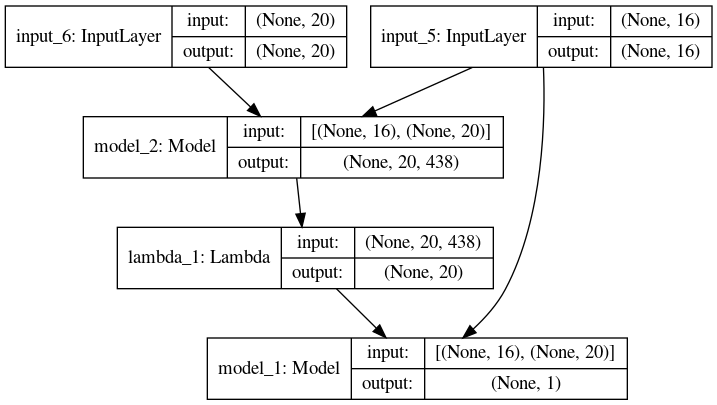

In [18]:
%matplotlib inline
from keras.utils.vis_utils import plot_model
from IPython.display import Image


latent_dim = 1024
dropout = 0.2

discriminator = build_discriminator(latent_dim, vocab_size, max_buggy_len, max_fixed_len)
plot_model(discriminator, to_file='discriminator_apr.png', show_shapes=True, show_layer_names=True)
# Image('discriminator_model_plot.png')

generator = build_generator(latent_dim, vocab_size, dropout, max_buggy_len, max_fixed_len)
plot_model(generator, to_file='generator_apr.png', show_shapes=True, show_layer_names=True)
# Image('generator_model_plot.png')

gan = build_gan(generator, discriminator, max_buggy_len, max_fixed_len)
plot_model(gan, to_file='gan_model_apr.png', show_shapes=True, show_layer_names=True)
gan.summary()
Image('gan_model_apr.png')

In [19]:
def generate_fixed_ints(gen, bugs, fixed_len, token_map, int_map):
    gntd_ints = np.zeros(shape=(len(bugs), fixed_len))
    gntd_ints[:, 0] = token_map["<soc>"]
    for buggy, generated in zip(bugs, gntd_ints):
        buggy_input = buggy[np.newaxis]
        gntd_in_out = generated[np.newaxis]
        for i in range(1, fixed_len):
            prediction = gen.predict([buggy_input, gntd_in_out]).argmax(axis=2)
            if int_map[prediction[:, i][0]] == "<eoc>":
                break
            generated[i] = prediction[:, i]
    
    return gntd_ints

In [20]:
import datetime
from tqdm import tqdm


epochs = 30

start_time = datetime.datetime.now().replace(microsecond=0)
for e in tqdm(range(epochs)):
#     print('Iteration', str(e)+'/'+str(epochs)+':-')
    discriminator.fit([buggy_inputs, fixed_inputs], np.ones(num_dps))
    generated_ints = generate_fixed_ints(generator, buggy_inputs, max_fixed_len, token_int_map, int_token_map)
    discriminator.fit([buggy_inputs, generated_ints], np.zeros(num_dps))
    gan.fit([buggy_inputs, fixed_inputs], [np.ones(num_dps), fixed_outputs])
end_time = datetime.datetime.now().replace(microsecond=0)

  0%|          | 0/30 [00:00<?, ?it/s]/home/aziz/anaconda3/envs/tf/lib/python3.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 1/1
100/100 [==============================] - 4s 36ms/step - loss: 0.2624 - acc: 0.7300
Epoch 1/1
 96/100 [===========================>..] - ETA: 0s - loss: 3.5634 - acc: 0.0000e+00

/home/aziz/anaconda3/envs/tf/lib/python3.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


100/100 [==============================] - 0s 3ms/step - loss: 3.4352 - acc: 0.0100
Epoch 1/1
100/100 [==============================] - 2s 24ms/step - loss: 720.5336 - model_1_loss: 0.3616 - model_2_loss: 7.2017


  3%|▎         | 1/30 [00:44<21:32, 44.57s/it]

Epoch 1/1
 64/100 [==================>...........] - ETA: 0s - loss: 0.1139 - acc: 1.0000

/home/aziz/anaconda3/envs/tf/lib/python3.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


100/100 [==============================] - 0s 3ms/step - loss: 0.1114 - acc: 1.0000
Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 0.3093 - acc: 0.9900
Epoch 1/1
100/100 [==============================] - 0s 4ms/step - loss: 494.6174 - model_1_loss: 0.1578 - model_2_loss: 4.9446


  7%|▋         | 2/30 [00:57<16:22, 35.10s/it]

Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 0.0581 - acc: 1.0000
Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 0.2048 - acc: 1.0000
Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 434.9246 - model_1_loss: 0.9054 - model_2_loss: 4.3402


 10%|█         | 3/30 [01:18<13:53, 30.86s/it]

Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 0.0244 - acc: 1.0000
Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 0.1845 - acc: 1.0000
Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 396.7969 - model_1_loss: 0.4009 - model_2_loss: 3.9640


 13%|█▎        | 4/30 [01:35<11:32, 26.63s/it]

Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 0.0113 - acc: 1.0000
Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 0.0343 - acc: 1.0000
Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 371.2297 - model_1_loss: 0.7094 - model_2_loss: 3.7052


 17%|█▋        | 5/30 [01:51<09:46, 23.46s/it]

Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 0.0111 - acc: 1.0000
Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 0.0140 - acc: 1.0000
Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 359.3399 - model_1_loss: 0.4356 - model_2_loss: 3.5890


 20%|██        | 6/30 [02:02<07:51, 19.63s/it]

Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 0.0054 - acc: 1.0000
Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 0.0077 - acc: 1.0000
Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 324.7918 - model_1_loss: 0.2538 - model_2_loss: 3.2454


 23%|██▎       | 7/30 [02:11<06:22, 16.62s/it]

Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 0.0018 - acc: 1.0000
Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 0.0170 - acc: 1.0000
Epoch 1/1
100/100 [==============================] - 0s 4ms/step - loss: 294.5067 - model_1_loss: 0.0911 - model_2_loss: 2.9442


 27%|██▋       | 8/30 [02:22<05:26, 14.83s/it]

Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 0.0021 - acc: 1.0000
Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 0.0076 - acc: 1.0000
Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 267.5986 - model_1_loss: 0.4422 - model_2_loss: 2.6716


 30%|███       | 9/30 [02:37<05:11, 14.81s/it]

Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 0.0122 - acc: 0.9900
Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 0.0303 - acc: 1.0000
Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 248.7904 - model_1_loss: 0.5028 - model_2_loss: 2.4829


 33%|███▎      | 10/30 [03:00<05:46, 17.32s/it]

Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 3.4474e-04 - acc: 1.0000
Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 0.0132 - acc: 1.0000
Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 253.5872 - model_1_loss: 0.9127 - model_2_loss: 2.5267


 37%|███▋      | 11/30 [03:14<05:13, 16.49s/it]

Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 5.2014e-04 - acc: 1.0000
Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 0.0171 - acc: 1.0000
Epoch 1/1
100/100 [==============================] - 0s 4ms/step - loss: 216.7351 - model_1_loss: 0.1568 - model_2_loss: 2.1658


 40%|████      | 12/30 [03:29<04:45, 15.84s/it]

Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 0.0025 - acc: 1.0000
Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 0.0029 - acc: 1.0000
Epoch 1/1
100/100 [==============================] - 0s 4ms/step - loss: 181.6984 - model_1_loss: 0.1657 - model_2_loss: 1.8153


 43%|████▎     | 13/30 [03:44<04:28, 15.81s/it]

Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 0.0035 - acc: 1.0000
Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 7.4882e-04 - acc: 1.0000
Epoch 1/1
100/100 [==============================] - 0s 4ms/step - loss: 165.5727 - model_1_loss: 0.3596 - model_2_loss: 1.6521


 47%|████▋     | 14/30 [03:59<04:08, 15.53s/it]

Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 3.4876e-04 - acc: 1.0000
Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 0.0016 - acc: 1.0000
Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 148.0644 - model_1_loss: 0.0710 - model_2_loss: 1.4799


 50%|█████     | 15/30 [04:11<03:36, 14.41s/it]

Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 1.4148e-04 - acc: 1.0000
Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 0.0015 - acc: 1.0000
Epoch 1/1
100/100 [==============================] - 0s 4ms/step - loss: 138.7589 - model_1_loss: 0.0642 - model_2_loss: 1.3869


 53%|█████▎    | 16/30 [04:24<03:17, 14.09s/it]

Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 1.1223e-04 - acc: 1.0000
Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 0.0100 - acc: 1.0000
Epoch 1/1
100/100 [==============================] - 0s 4ms/step - loss: 140.0276 - model_1_loss: 0.5199 - model_2_loss: 1.3951


 57%|█████▋    | 17/30 [04:42<03:15, 15.05s/it]

Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 1.5575e-04 - acc: 1.0000
Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 9.5167e-04 - acc: 1.0000
Epoch 1/1
100/100 [==============================] - 0s 4ms/step - loss: 112.5979 - model_1_loss: 0.2762 - model_2_loss: 1.1232


 60%|██████    | 18/30 [04:57<03:01, 15.10s/it]

Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 2.7041e-04 - acc: 1.0000
Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 5.4523e-04 - acc: 1.0000
Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 102.1322 - model_1_loss: 0.2053 - model_2_loss: 1.0193


 63%|██████▎   | 19/30 [05:10<02:39, 14.46s/it]

Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 3.3209e-04 - acc: 1.0000
Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 3.6782e-04 - acc: 1.0000
Epoch 1/1
100/100 [==============================] - 0s 4ms/step - loss: 87.3269 - model_1_loss: 0.0983 - model_2_loss: 0.8723


 67%|██████▋   | 20/30 [05:21<02:13, 13.37s/it]

Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 2.8120e-04 - acc: 1.0000
Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 6.5109e-04 - acc: 1.0000
Epoch 1/1
100/100 [==============================] - 0s 4ms/step - loss: 78.1710 - model_1_loss: 0.1591 - model_2_loss: 0.7801


 70%|███████   | 21/30 [05:35<02:01, 13.52s/it]

Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 1.9899e-04 - acc: 1.0000
Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 0.0019 - acc: 1.0000
Epoch 1/1
100/100 [==============================] - 0s 4ms/step - loss: 58.2522 - model_1_loss: 6.0693e-04 - model_2_loss: 0.5825


 73%|███████▎  | 22/30 [05:48<01:47, 13.39s/it]

Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 1.6453e-04 - acc: 1.0000
Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 3.7377e-04 - acc: 1.0000
Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 57.0716 - model_1_loss: 3.3088e-04 - model_2_loss: 0.5707


 77%|███████▋  | 23/30 [06:00<01:32, 13.20s/it]

Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 1.6179e-04 - acc: 1.0000
Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 7.1037e-04 - acc: 1.0000
Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 53.2406 - model_1_loss: 0.0885 - model_2_loss: 0.5315


 80%|████████  | 24/30 [06:13<01:19, 13.17s/it]

Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 1.4426e-04 - acc: 1.0000
Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 4.6721e-04 - acc: 1.0000
Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 51.6989 - model_1_loss: 5.7148e-04 - model_2_loss: 0.5170


 83%|████████▎ | 25/30 [06:25<01:03, 12.75s/it]

Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 1.2369e-04 - acc: 1.0000
Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 2.9630e-04 - acc: 1.0000
Epoch 1/1
100/100 [==============================] - 0s 4ms/step - loss: 52.7527 - model_1_loss: 0.1965 - model_2_loss: 0.5256


 87%|████████▋ | 26/30 [06:40<00:52, 13.20s/it]

Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 1.0675e-04 - acc: 1.0000
Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 3.5291e-04 - acc: 1.0000
Epoch 1/1
100/100 [==============================] - 0s 4ms/step - loss: 50.8096 - model_1_loss: 0.0920 - model_2_loss: 0.5072


 90%|█████████ | 27/30 [06:51<00:38, 12.83s/it]

Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 9.1510e-05 - acc: 1.0000
Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 3.2580e-04 - acc: 1.0000
Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 40.0741 - model_1_loss: 0.0870 - model_2_loss: 0.3999


 93%|█████████▎| 28/30 [07:04<00:25, 12.68s/it]

Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 8.1473e-05 - acc: 1.0000
Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 1.8993e-04 - acc: 1.0000
Epoch 1/1
100/100 [==============================] - 0s 4ms/step - loss: 35.2044 - model_1_loss: 5.4795e-04 - model_2_loss: 0.3520


 97%|█████████▋| 29/30 [07:17<00:12, 12.73s/it]

Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 7.3880e-05 - acc: 1.0000
Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 3.8249e-04 - acc: 1.0000
Epoch 1/1
100/100 [==============================] - 0s 3ms/step - loss: 29.5122 - model_1_loss: 1.0582e-04 - model_2_loss: 0.2951


100%|██████████| 30/30 [07:29<00:00, 12.48s/it]


In [21]:
print("Training took (h:mm:ss)", end_time-start_time)

def decode_ints(int_matrix, int_map):
    gntd_codes = []
    for ints in int_matrix:
        code = [int_map[x] for x in ints if x != 0]
        gntd_codes.append(code)
        
    return gntd_codes

Training took (h:mm:ss) 0:07:29


In [22]:
generated_ints = generate_fixed_ints(generator, buggy_inputs, max_fixed_len, token_int_map, int_token_map)
generated_codes = decode_ints(generated_ints, int_token_map)
for buggy, fixed, gnrtd in zip(buggy_codes, fixed_codes, generated_codes):
    print('Buggy code:', ' '.join(buggy))
    print('---')
    print('Fixed code:', ' '.join(fixed[1:-1]))
    print('Genration: ', ' '.join(gnrtd[1:]))
    print('=============')
    print('=============')

Buggy code: String toTest = "woordenboek_nederlands-3.1.1-sm+tb+fx+fn.xpi";
---
Fixed code: String toTest = "turkmen_spell_checker_dictionary-0.1.6-tb+fx+sm.xpi";
Genration:  String toTest = "turkmen_spell_checker_dictionary-0.1.6-tb+fx+sm.xpi";
Buggy code: || (this.collator != null && ! this.collator.equals(other.collator))
---
Fixed code: || (this.collator != null && ! this.collator.equals(other.collator) || (this.collator == null && other.collator != null))
Genration:  || (this.collator != null && ! this.collator.equals(other.collator) || (this.collator == null && other.collator != null))
Buggy code: dest = _dpMgr.planDeployment(vmProfile, plan, exclude);
---
Fixed code: dest = _dpMgr.planDeployment(vmProfile, plan, exclude, null);
Genration:  dest = _dpMgr.planDeployment(vmProfile, plan, exclude, null);
Buggy code: LOG.info(clazz + " is not a valid POJO type");
---
Fixed code: LOG.info(clazz + " is not a valid POJO type because not all fields are valid POJO fields.");
Genration:  L